In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

In [2]:
def print_score(eval_metric, args):
    print(f"{eval_metric.__name__}: {round(eval_metric(*args), 2)}")

In [3]:
from src.utils.metrics import METRICS
METRICS["DISCO"].__name__ = "disco_score"
METRICS["DBCV"].__name__ = "dbcv_score"
METRICS["DCSI"].__name__ = "dcsi_score"
METRICS.keys()

dict_keys(['DISCO', 'DBCV', 'DCSI', 'LCCV', 'VIASCKDE', 'CVDD', 'CDBW', 'CVNN', 'S_DBW', 'SILHOUETTE'])

In [4]:
from datasets.density_datasets import Datasets as DensityDatasets
import numpy as np
import matplotlib.pyplot as plt

X, l1 = DensityDatasets.dartboard1.standardized_data_cached

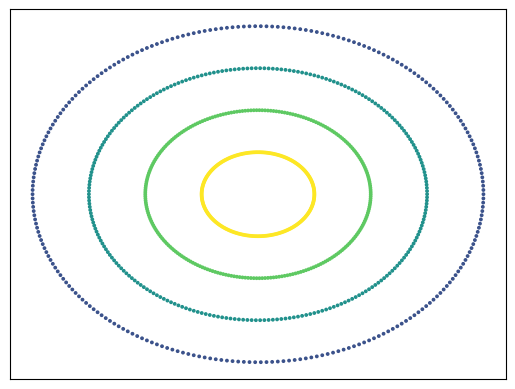

In [5]:
plt.scatter(X[:, 0], X[:, 1], s=3, c=l1, vmin=-1, vmax=len(set(l1)) - 1)
plt.xticks([])
plt.yticks([])
plt.show()
# plt.savefig("imgs/motivation/dartboard1.png")

In [6]:
for eval_metric in METRICS.values():
    print_score(eval_metric, [X, l1])

disco_score: 0.87
dbcv_score: 0.03
dcsi_score: 1.0
lccv_score: 0.68
viasckde_score: 0.48
cvdd_score: 44912.94
cdbw_score: 0.0
cvnn_score: 6.76
sdbw_score: 1.62
silhouette_score: -0.04


In [7]:
from sklearn.cluster import KMeans
np.random.seed(0)
l1_ = KMeans(4).fit_predict(X)

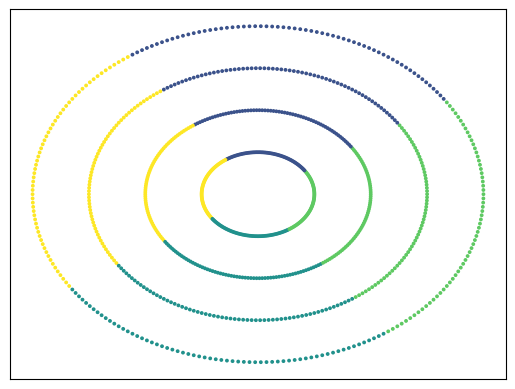

In [8]:
plt.scatter(X[:, 0], X[:, 1], s=3, c=l1_, vmin=-1, vmax=len(set(l1)) - 1)
plt.xticks([])
plt.yticks([])
plt.show()
# plt.savefig("imgs/motivation/dartboard_kmeans.png")

In [9]:
for eval_metric in METRICS.values():
    print_score(eval_metric, [X, l1_])

disco_score: -0.01
dbcv_score: -0.18
dcsi_score: 0.22
lccv_score: 0.03
viasckde_score: 0.37
cvdd_score: 0.62
cdbw_score: 0.04
cvnn_score: 4.17
sdbw_score: 2.13
silhouette_score: 0.32


In [10]:
from src.utils.data import add_noise

np.random.seed(0)
X_noise, l2 = add_noise(X, l1, 200, 0.2, 0.07)

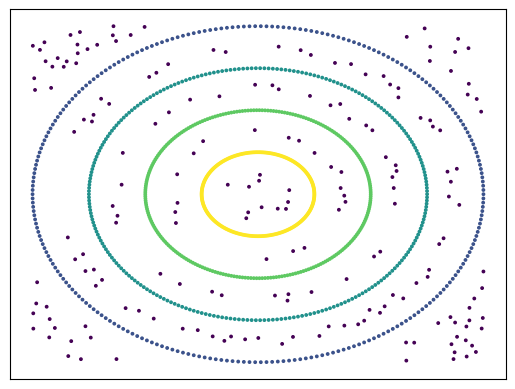

In [11]:
plt.scatter(X_noise[:, 0], X_noise[:, 1], s=3, c=l2, vmin=-1, vmax=len(set(l1)) - 1)
plt.xticks([])
plt.yticks([])
plt.show()
# plt.savefig("imgs/motivation/dartboard_noise.png")

In [12]:
for eval_metric in METRICS.values():
    print_score(eval_metric, [X_noise, l2])

disco_score: 0.67
dbcv_score: 0.03
dcsi_score: 1.0
lccv_score: 0.67
viasckde_score: 0.21
cvdd_score: 12015.01
cdbw_score: 0.0
cvnn_score: 6.74
sdbw_score: 1.62
silhouette_score: -0.08


In [13]:
l2_ = l2.copy()
idx = np.where(X[:, 0] > 0)[0]

l2_[idx] = -1

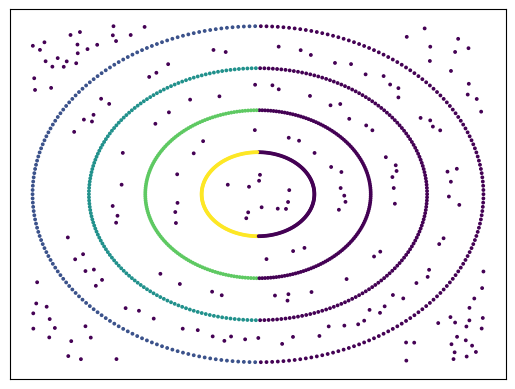

In [14]:
plt.scatter(X_noise[:, 0], X_noise[:, 1], s=3, c=l2_, vmin=-1, vmax=len(set(l1)) - 1)
plt.xticks([])
plt.yticks([])
plt.show()
# plt.savefig("imgs/motivation/dartboard_noise_split.png")

In [15]:
for eval_metric in METRICS.values():
    print_score(eval_metric, [X_noise, l2_])

disco_score: 0.22
dbcv_score: 0.03
dcsi_score: 1.0
lccv_score: 0.36
viasckde_score: 0.38
cvdd_score: 800.09
cdbw_score: 0.01
cvnn_score: 4.95
sdbw_score: 1.54
silhouette_score: -0.03
